In [1]:
%load_ext watermark
%watermark -v -p numpy,scipy,sklearn,pandas,matplotlib

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
scipy 1.2.1
sklearn 0.20.2
pandas 0.24.1
matplotlib 3.0.2


In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

np.random.seed(2)

In [3]:
titanic_train = pd.read_csv("titanic/train.csv")
titanic_test = pd.read_csv("titanic/test.csv")

In [4]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print(titanic_train.shape, titanic_test.shape)

(891, 12) (418, 11)


In [6]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


categorical feature : Pclass, Sex, Ticket, Cabin, Embarked<br>
numeric feature : Age, SibSp, Parch, Fare<br>
feature not to use : PassengerId, Name<br>
target : Survived

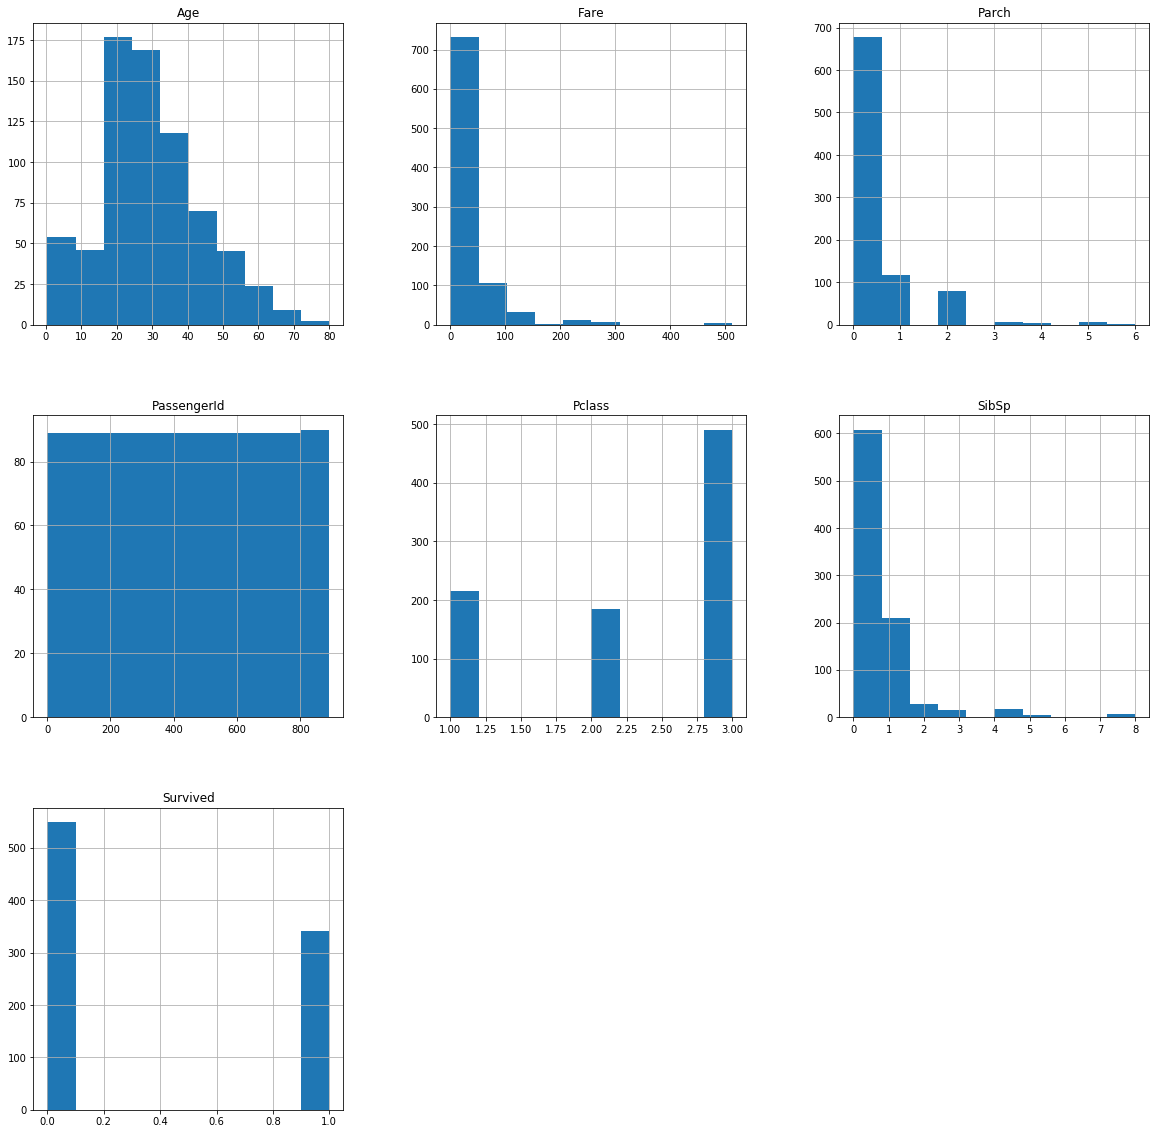

In [7]:
titanic_train.hist(figsize=(20, 20))
plt.show()

In [8]:
corr_matrix = titanic_train.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [9]:
titanic_train["Family"] = titanic_train["Parch"] + titanic_train["SibSp"]

In [10]:
corr_matrix = titanic_train.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
Family         0.016639
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [11]:
titanic_train = titanic_train.drop("Family", axis=1)
X_train = titanic_train.drop("Survived", axis=1)
y_train = titanic_train["Survived"]

In [12]:
permutation = np.random.permutation(len(X_train))

X_train, y_train = X_train.iloc[permutation], y_train.iloc[permutation]

In [13]:
print(X_train.shape, y_train.shape)

(891, 11) (891,)


In [14]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('one_hot', OneHotEncoder(categories='auto', sparse=False))
    ])
full_pipeline = ColumnTransformer([
        ('num', SimpleImputer(strategy='most_frequent'), num_attribs),
        ('cat', cat_pipeline, cat_attribs)
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(max_depth=2, warm_start=True,
                                  n_iter_no_change=100)
gbrt.fit(X_train_prepared, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=100, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=True)

In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(gbrt, X_train_prepared, y_train, cv=5)

array([0.81564246, 0.83240223, 0.80898876, 0.83707865, 0.79661017])

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
rnd_clf.fit(X_train_prepared, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
cross_val_score(rnd_clf, X_train_prepared, y_train, cv=5)

array([0.83240223, 0.83240223, 0.81460674, 0.78651685, 0.76271186])

In [19]:
from sklearn.ensemble import ExtraTreesClassifier

cross_val_score(ExtraTreesClassifier(n_estimators=200),
                X_train_prepared, y_train, cv=5, n_jobs=-1)

array([0.79888268, 0.83240223, 0.79213483, 0.7752809 , 0.75706215])

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs_gbrt = {
        'learning_rate': np.arange(0.1, 1.3, 0.3),
        'max_depth': np.arange(1, 10)
    }

gbrt = GradientBoostingClassifier(warm_start=True, n_iter_no_change=100)
rnd_search_gbrt = RandomizedSearchCV(gbrt, param_distributions=param_distribs_gbrt,
                                     n_iter=10, cv=5, scoring='accuracy',
                                     n_jobs=-1, verbose=2)

In [21]:
rnd_search_gbrt.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.3s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...       subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=True),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': array([0.1, 0.4, 0.7, 1. ]), 'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [22]:
def search_results(rnd_search):
    cvres = rnd_search.cv_results_
    for mean_score, params, rank in zip(cvres["mean_test_score"], cvres["params"],
                                        cvres["rank_test_score"]):
        print(mean_score, params, rank)
        
search_results(rnd_search_gbrt)

0.8058361391694725 {'max_depth': 8, 'learning_rate': 0.7000000000000001} 5
0.7946127946127947 {'max_depth': 4, 'learning_rate': 0.4} 7
0.8002244668911336 {'max_depth': 9, 'learning_rate': 0.7000000000000001} 6
0.8181818181818182 {'max_depth': 1, 'learning_rate': 0.7000000000000001} 1
0.8069584736251403 {'max_depth': 1, 'learning_rate': 0.1} 3
0.7946127946127947 {'max_depth': 5, 'learning_rate': 0.7000000000000001} 7
0.8069584736251403 {'max_depth': 6, 'learning_rate': 0.4} 3
0.7946127946127947 {'max_depth': 7, 'learning_rate': 1.0000000000000002} 7
0.7934904601571269 {'max_depth': 2, 'learning_rate': 0.7000000000000001} 10
0.8148148148148148 {'max_depth': 4, 'learning_rate': 0.1} 2


In [23]:
param_distribs_rfc = {
        'n_estimators': np.arange(100, 700, 100),
        'max_leaf_nodes': np.arange(2, 32),
        'max_features': ["auto", "log2", None]
    }

rnd_clf = RandomForestClassifier(n_jobs=-1)
rnd_search_rfc = RandomizedSearchCV(rnd_clf, param_distributions=param_distribs_rfc,
                                    n_iter=10, cv=5, scoring='accuracy',
                                    n_jobs=-1, verbose=3)

In [24]:
rnd_search_rfc.fit(X_train_prepared, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.9s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([100, 200, 300, 400, 500, 600]), 'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]), 'max_features': ['auto', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=3)

In [25]:
search_results(rnd_search_rfc)

0.8237934904601572 {'n_estimators': 400, 'max_leaf_nodes': 18, 'max_features': None} 1
0.7811447811447811 {'n_estimators': 200, 'max_leaf_nodes': 2, 'max_features': 'auto'} 10
0.819304152637486 {'n_estimators': 400, 'max_leaf_nodes': 31, 'max_features': 'auto'} 6
0.8159371492704826 {'n_estimators': 200, 'max_leaf_nodes': 30, 'max_features': 'log2'} 8
0.8181818181818182 {'n_estimators': 300, 'max_leaf_nodes': 8, 'max_features': None} 7
0.8204264870931538 {'n_estimators': 200, 'max_leaf_nodes': 26, 'max_features': 'log2'} 3
0.8204264870931538 {'n_estimators': 400, 'max_leaf_nodes': 29, 'max_features': 'auto'} 3
0.8215488215488216 {'n_estimators': 300, 'max_leaf_nodes': 31, 'max_features': 'log2'} 2
0.7890011223344556 {'n_estimators': 400, 'max_leaf_nodes': 4, 'max_features': 'log2'} 9
0.8204264870931538 {'n_estimators': 600, 'max_leaf_nodes': 27, 'max_features': None} 3


In [26]:
param_distribs_xtree = {
        'n_estimators': np.arange(500, 1000, 100),
        'criterion': ["gini", "entropy"],
        'max_depth': np.arange(10, 30, 2)
    }

xtree_clf = ExtraTreesClassifier(n_jobs=-1)
rnd_search_xtree = RandomizedSearchCV(xtree_clf, param_distributions=param_distribs_xtree,
                                      n_iter=10, cv=5, scoring='accuracy',
                                      n_jobs=-1, verbose=3)

In [27]:
rnd_search_xtree.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   52.5s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([500, 600, 700, 800, 900]), 'criterion': ['gini', 'entropy'], 'max_depth': array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=3)

In [28]:
search_results(rnd_search_xtree)

0.8080808080808081 {'n_estimators': 900, 'max_depth': 14, 'criterion': 'entropy'} 4
0.7968574635241302 {'n_estimators': 700, 'max_depth': 18, 'criterion': 'gini'} 7
0.8092031425364759 {'n_estimators': 700, 'max_depth': 10, 'criterion': 'gini'} 2
0.8103254769921436 {'n_estimators': 800, 'max_depth': 14, 'criterion': 'gini'} 1
0.8092031425364759 {'n_estimators': 600, 'max_depth': 10, 'criterion': 'gini'} 2
0.7878787878787878 {'n_estimators': 900, 'max_depth': 26, 'criterion': 'gini'} 10
0.7901234567901234 {'n_estimators': 600, 'max_depth': 28, 'criterion': 'gini'} 8
0.8047138047138047 {'n_estimators': 900, 'max_depth': 12, 'criterion': 'gini'} 5
0.7991021324354658 {'n_estimators': 600, 'max_depth': 18, 'criterion': 'entropy'} 6
0.7890011223344556 {'n_estimators': 500, 'max_depth': 26, 'criterion': 'entropy'} 9


In [29]:
from sklearn.ensemble import VotingClassifier

gbrt_best = rnd_search_gbrt.best_estimator_
rf_clf_best = rnd_search_rfc.best_estimator_
xtree_best = rnd_search_xtree.best_estimator_

voting_clf = VotingClassifier(
    estimators=[('gbrt', gbrt_best), ('rf', rf_clf_best), ('xtree', xtree_best)],
    voting='soft')
voting_clf.fit(X_train_prepared, y_train)

VotingClassifier(estimators=[('gbrt', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.7000000000000001, loss='deviance',
              max_depth=1, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min...mators=800, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [30]:
X_test_prepared = full_pipeline.transform(titanic_test)

In [31]:
y_pred = voting_clf.predict(X_test_prepared)

In [33]:
pred_df = DataFrame({"PassengerId": titanic_test.PassengerId,
                     "Survived": y_pred})
pred_df.to_csv("submission2.csv", index=False)